# H02C8b Information Retrieval and Search Engines: RAG Project

Welcome to the notebook companion for the IRSE project. You will find all starter code here. You are encouraged to use this code, as it has been confirmed to work for the RAG pipeline described in the assignment handout. However, you are certainly welcome to make any changes you see fit, provided that your code is written in Python and runs without issue.

**IMPORTANT**: Do not submit a notebook as your final solution. It will not be graded. Refer to assignment handout for more information about the submission format.

**IMPORTANT**: Be mindful of your runtime usage, if working in Colab. At the beginning of every session, navigate to the top menu bar in Colab and select **Runtime > Change runtime type > CPU (Python 3)**. This will ensure that your session runs on CPU and that you do not waste any GPU allocation for the day. GPUs are provided by Google on a limited daily basis, and access is given every 24 hours. It is best that you complete the TF-IDF/search component before loading models and running inference on the GPU runtime.


If you have any questions, feel free to email [Thomas](mailto:thomas.bauwens@kuleuven.be) or [Kushal](mailto:kushaljayesh.tatariya@kuleuven.be).

## RAG for recipe recommendation:

We will begin by installing the huggingface `datasets` library for easily loading our data.

In [ ]:
# ! pip -q install datasets
# !wget https://people.cs.kuleuven.be/~thomas.bauwens/irse_documents_2025_recipes.parquet
# !wget https://people.cs.kuleuven.be/~thomas.bauwens/irse_queries_2025_recipes.json


In [ ]:
import json
import nltk
import numpy as np
import pandas as pd
import json
import string
import datasets
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import math
import numpy as np
from nltk.corpus import stopwords

import string
from nltk.tokenize import word_tokenize
import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

tqdm.pandas()  # Show progress bar if using pandas

import nltk

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download("wordnet")

# from google.colab import userdata
# userdata.get("HF_TOKEN")

In [ ]:
dataset = datasets.load_dataset(
    "parquet", data_files="./irse_documents_2025_recipes.parquet"
)["train"]
queries_data = json.load(open("./irse_queries_2025_recipes.json", "r"))

df = dataset.to_pandas()

# Now you can apply the function to concatenate columns
recipies = df.apply(
    lambda row: f"{row['name']} {row['description']} {row['ingredients']} {row['steps']}",
    axis=1,
)  # [:10000]
recipe_ids = dataset["official_id"]  # [:10000]
print("Number of documents:", len(recipies))

queries = pd.DataFrame(columns=["q", "r", "a"])
for query_item in queries_data["queries"]:
    query_text = query_item["q"]
    relevance_pairs = query_item["r"]
    answer = query_item["a"]
    queries = pd.concat(
        [
            queries,
            pd.DataFrame({"q": [query_text], "r": [relevance_pairs], "a": [answer]}),
        ],
        ignore_index=True,
    )

print("Number of queries:", len(queries))

In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def preprocess_fast(doc):
    doc = doc.translate(str.maketrans("", "", string.punctuation)).lower()

    words = word_tokenize(doc)

    words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in stop_words  # and word.isalpha()
    ]

    return " ".join(words)


preprocessed_recipes = [preprocess_fast(doc) for doc in tqdm(recipies)]


#### Preprocessor

In [ ]:
# lemmatizer = WordNetLemmatizer()
# counter = 0


# def preprocess(doc):
#     global counter
#     counter += 1
#     if counter % 1000 == 0:
#         print(f"Processed: {counter}")
#     doc = doc.split()
#     preprocessed_text = []
#     for text in doc:
#         text = text.translate(str.maketrans("", "", string.punctuation))
#         text = text.lower()
#         words = word_tokenize(text)
#         words = [word for word in words if word not in stopwords.words("english")]
#         words = [lemmatizer.lemmatize(word) for word in words]
#         if words != []:
#             preprocessed_text.append(words[0])
#     return preprocessed_text
# vectorizer = TfidfVectorizer(tokenizer=preprocess)
# X = vectorizer.fit_transform(recipies)
# print("fitted")
# tfidf_df = pd.DataFrame(
#     X.toarray(), index=range(len(recipies)), columns=vectorizer.get_feature_names_out()
# )


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_recipes)
print("TF-IDF fitted")

# # Optional: convert to DataFrame (can be memory-heavy)
# tfidf_df = pd.DataFrame(
#     X.toarray(), index=range(len(preprocessed_recipes)), columns=vectorizer.get_feature_names_out()
# )


#### TF-IDF

In [ ]:
def calculate_precision_recall_f1_optimized(relevant_doc_ids, retrieved_doc_ids):
    # Convert to sets for faster operations
    relevant_set = set(relevant_doc_ids)
    retrieved_set = set(retrieved_doc_ids)

    # Calculate true positives (documents that are both relevant and retrieved)
    true_positives = len(relevant_set.intersection(retrieved_set))

    # Calculate precision, recall, and F1
    if len(retrieved_set) == 0:
        precision = 0.0
        recall = 0.0 if len(relevant_set) > 0 else 1.0
        f1 = 0.0
    elif len(relevant_set) == 0:
        precision = 0.0
        recall = 1.0
        f1 = 0.0
    else:
        precision = true_positives / len(retrieved_set)
        recall = true_positives / len(relevant_set)
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0.0

    return {"precision": precision, "recall": recall, "f1": f1}


def calculate_macro_averages(metrics_per_query):
    # This function remains the same
    precision_values = [metrics["precision"] for metrics in metrics_per_query]
    recall_values = [metrics["recall"] for metrics in metrics_per_query]
    f1_values = [metrics["f1"] for metrics in metrics_per_query]

    macro_precision = np.mean(precision_values)
    macro_recall = np.mean(recall_values)
    macro_f1 = np.mean(f1_values)

    return {
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
    }


def calculate_micro_averages_optimized(all_relevant_doc_ids, all_retrieved_doc_ids):
    # Flatten lists of relevant and retrieved document IDs
    all_relevant = [
        doc_id for query_relevant in all_relevant_doc_ids for doc_id in query_relevant
    ]
    all_retrieved = [
        doc_id
        for query_retrieved in all_retrieved_doc_ids
        for doc_id in query_retrieved
    ]

    # Count true positives across all queries
    relevant_set = set(all_relevant)
    retrieved_set = set(all_retrieved)
    true_positives = len(relevant_set.intersection(retrieved_set))

    # Calculate micro-averaged metrics
    if len(retrieved_set) == 0:
        micro_precision = 0.0
        micro_recall = 0.0 if len(relevant_set) > 0 else 1.0
        micro_f1 = 0.0
    elif len(relevant_set) == 0:
        micro_precision = 0.0
        micro_recall = 1.0
        micro_f1 = 0.0
    else:
        micro_precision = true_positives / len(retrieved_set)
        micro_recall = true_positives / len(relevant_set)
        if micro_precision + micro_recall > 0:
            micro_f1 = (
                2 * micro_precision * micro_recall / (micro_precision + micro_recall)
            )
        else:
            micro_f1 = 0.0

    return {
        "micro_precision": micro_precision,
        "micro_recall": micro_recall,
        "micro_f1": micro_f1,
    }

In [ ]:
def retrieve_documents(query_text, recipies, recipe_ids, k=None, threshold=None):
    if len(recipies) != len(recipe_ids):
        raise ValueError("Recipes and recipe_ids must have the same length")
    if not k and not threshold:
        raise ValueError("Either k or threshold must be specified")
    if vectorizer is None or X is None:
        raise ValueError("Vectorizer and document matrix X must be provided")

    query = preprocess_fast(query_text)
    query_vector = vectorizer.transform([query])

    cosine_similarities = cosine_similarity(query_vector, X).flatten()

    results = [
        (recipies[i], recipe_ids[i], cosine_similarities[i])
        for i in range(len(recipies))
    ]
    results.sort(key=lambda x: x[2], reverse=True)

    if threshold:
        results = [r for r in results if r[2] >= threshold]

    if k:
        results = results[:k]

    return results


In [20]:
def evaluate_ir_system(queries, recipies, recipe_ids, k, threshold):
    metrics_per_query = []
    all_relevant_doc_ids = []
    all_retrieved_doc_ids = []

    for i, row in queries.iterrows():
        query_text = row["q"]
        relevant_doc_ids = row["r"]
        relevant_doc_ids = [doc[0] for doc in relevant_doc_ids]

        # print(f"\nProcessing query {i + 1}/{len(queries)}: {query_text}")

        results = retrieve_documents(query_text, recipies, recipe_ids, k, threshold)
        retrieved_doc_ids = [result[1] for result in results]

        query_metrics = calculate_precision_recall_f1_optimized(
            relevant_doc_ids, retrieved_doc_ids
        )
        metrics_per_query.append(query_metrics)

        all_relevant_doc_ids.append(relevant_doc_ids)
        all_retrieved_doc_ids.append(retrieved_doc_ids)

        # print(
        #     f"Query {i + 1} metrics: Precision={query_metrics['precision']:.4f}, "
        #     f"Recall={query_metrics['recall']:.4f}, F1={query_metrics['f1']:.4f}"
        # )

    macro_metrics = calculate_macro_averages(metrics_per_query)
    micro_metrics = calculate_micro_averages_optimized(
        all_relevant_doc_ids, all_retrieved_doc_ids
    )

    all_metrics = {**macro_metrics, **micro_metrics}

    return all_metrics

In [ ]:
evaluate_ir_system(queries.iloc[[34]], recipies, recipe_ids, k=5, threshold=0.5)

In [21]:
metrics = evaluate_ir_system(queries, recipies, recipe_ids, k=5, threshold=None)

print("\n===== IR System Evaluation Results =====")
print(f"Macro-average Precision: {metrics['macro_precision']:.4f}")
print(f"Macro-average Recall: {metrics['macro_recall']:.4f}")
print(f"Macro-average F1: {metrics['macro_f1']:.4f}")
print(f"Micro-average Precision: {metrics['micro_precision']:.4f}")
print(f"Micro-average Recall: {metrics['micro_recall']:.4f}")
print(f"Micro-average F1: {metrics['micro_f1']:.4f}")
print("========================================")


===== IR System Evaluation Results =====
Macro-average Precision: 0.2681
Macro-average Recall: 0.3284
Macro-average F1: 0.1838
Micro-average Precision: 0.3122
Micro-average Recall: 0.1209
Micro-average F1: 0.1743




--- Testing different threshold values ---


Threshold=0.10, Macro F1=0.1103, Micro F1=0.0191


Threshold=0.15, Macro F1=0.1679, Micro F1=0.0471


Threshold=0.20, Macro F1=0.2175, Micro F1=0.0872


Threshold=0.25, Macro F1=0.2180, Micro F1=0.1163


Threshold=0.30, Macro F1=0.1815, Micro F1=0.1493


Threshold=0.35, Macro F1=0.1303, Micro F1=0.1627


Threshold=0.40, Macro F1=0.1206, Micro F1=0.1580


Threshold=0.45, Macro F1=0.0820, Micro F1=0.1333


Threshold=0.50, Macro F1=0.0625, Micro F1=0.0826


--- Testing different k values ---


k=1, Macro F1=0.0837, Micro F1=0.0531


k=3, Macro F1=0.1593, Micro F1=0.1167


k=5, Macro F1=0.1838, Micro F1=0.1743


k=7, Macro F1=0.1914, Micro F1=0.2003


k=9, Macro F1=0.1993, Micro F1=0.2233


k=11, Macro F1=0.2016, Micro F1=0.2409


k=13, Macro F1=0.2053, Micro F1=0.2497


k=15, Macro F1=0.1976, Micro F1=0.2429


k=17, Macro F1=0.2014, Micro F1=0.2520


k=19, Macro F1=0.2027, Micro F1=0.2547


k=21, Macro F1=0.2024, Micro F1=0.2548


k=23, Macro F1=0.2016, Micro F1=0.2500


k=25, Macro F1=0.1986, Micro F1=0.2452


k=27, Macro F1=0.1917, Micro F1=0.2380


k=29, Macro F1=0.1918, Micro F1=0.2398


k=31, Macro F1=0.1902, Micro F1=0.2380


k=33, Macro F1=0.1851, Micro F1=0.2320


k=35, Macro F1=0.1823, Micro F1=0.2265


k=37, Macro F1=0.1809, Micro F1=0.2229


k=39, Macro F1=0.1785, Micro F1=0.2191


k=41, Macro F1=0.1736, Micro F1=0.2143


k=43, Macro F1=0.1699, Micro F1=0.2091


k=45, Macro F1=0.1671, Micro F1=0.2061


k=47, Macro F1=0.1633, Micro F1=0.2026


Evaluating parameters: 100%|██████████| 34/34 [17:38<00:00, 31.13s/it]

k=49, Macro F1=0.1618, Micro F1=0.1995

Best threshold: 0.25 (F1: 0.2180)
Best k: 13 (F1: 0.2053)
Overall best parameter: threshold=0.25 (F1: 0.2180)



Evaluating parameters:   0%|          | 0/34 [19:27<?, ?it/s]


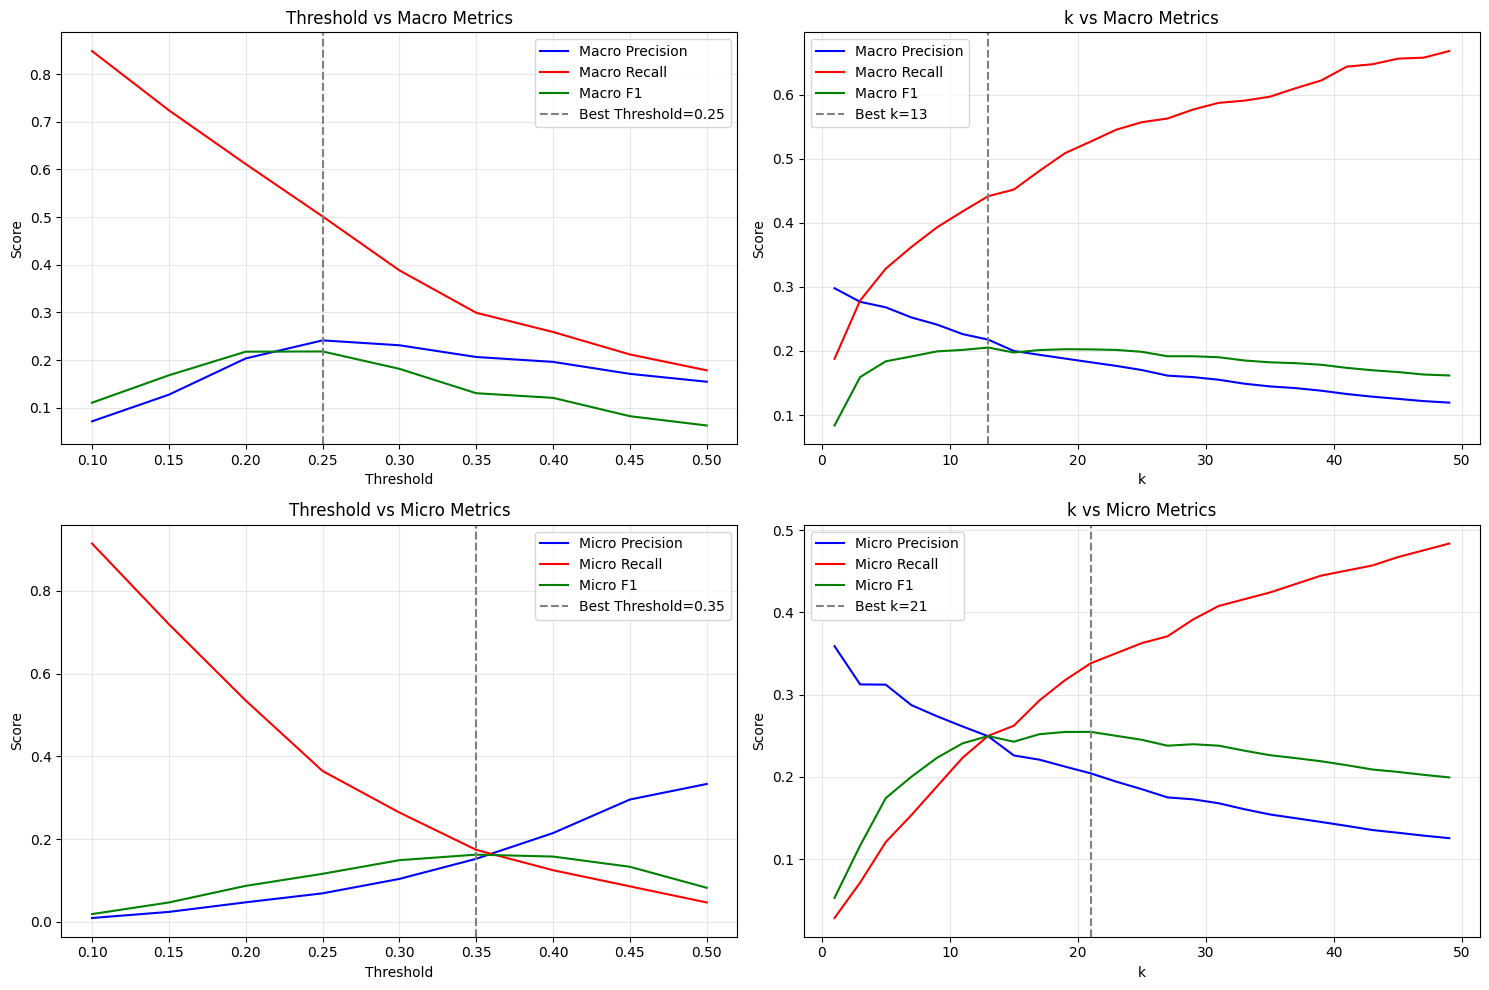



--- Testing combinations of k and threshold values ---


Evaluating combinations: 100%|██████████| 65/65 [31:53<00:00, 29.44s/it]


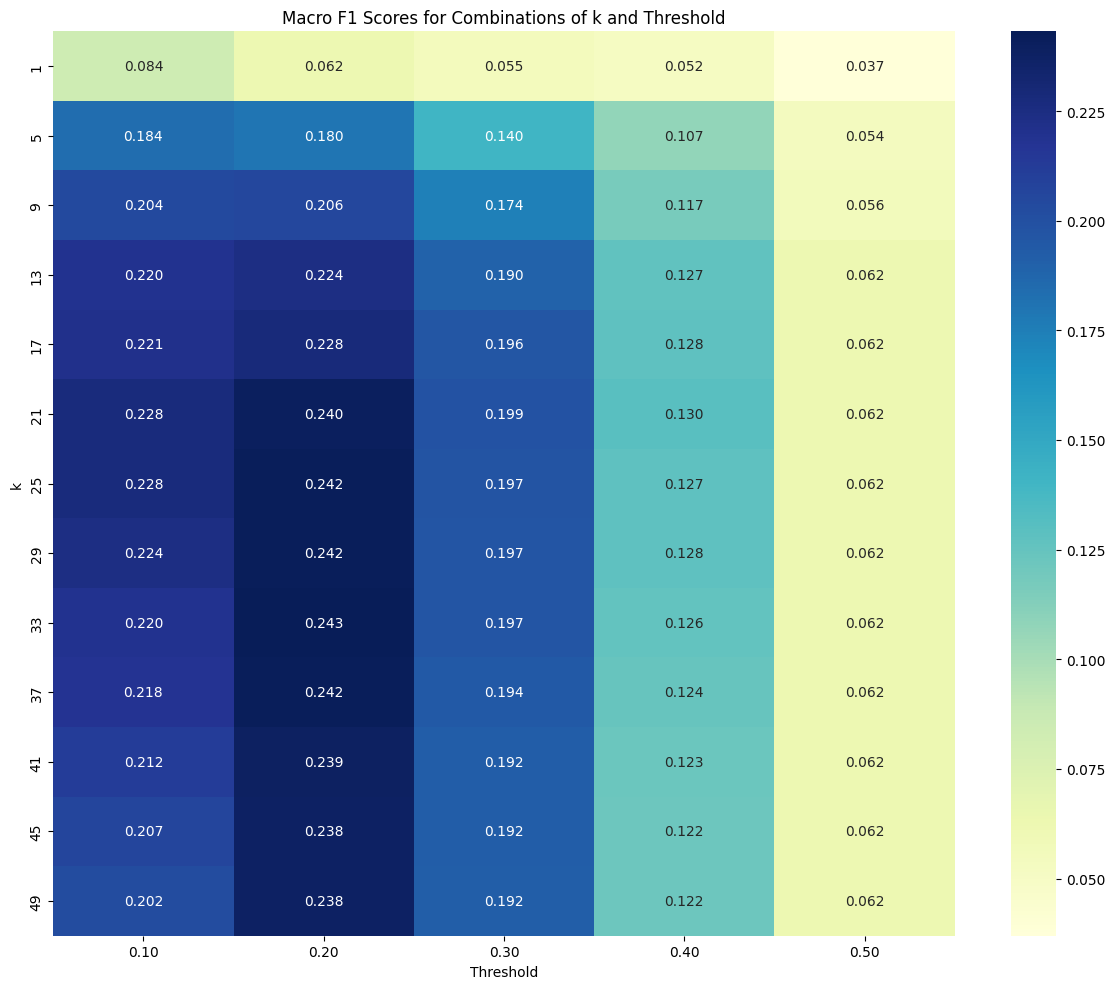



Final evaluation with best threshold:

===== IR System Evaluation Results with Optimal Parameters =====
Optimal parameters: threshold=0.25
Macro-average Precision: 0.2412
Macro-average Recall: 0.5015
Macro-average F1: 0.2180
Micro-average Precision: 0.0692
Micro-average Recall: 0.3648
Micro-average F1: 0.1163


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator


def find_optimal_parameters(queries, recipies, recipe_ids):
    """
    Find optimal threshold and k values for the retrieval system.

    Args:
        queries: DataFrame containing queries and relevant document IDs
        recipies: List of recipe documents
        recipe_ids: List of recipe IDs

    Returns:
        Dictionary with optimal parameters and results
    """
    # Define parameter ranges
    thresholds = np.arange(0.1, 0.51, 0.05)  # 0.1 to 0.5 with 0.05 step
    k_values = np.arange(1, 51, 2)  # 1 to 50 with step of 2

    # Results storage
    results = []

    # Progress bar for the entire process
    total_iterations = len(thresholds) + len(k_values)
    progress_bar = tqdm(total=total_iterations, desc="Evaluating parameters")

    # Evaluate fixed k values with varying thresholds
    print("\n\n--- Testing different threshold values ---")
    for threshold in thresholds:
        metrics = evaluate_ir_system(
            queries, recipies, recipe_ids, k=None, threshold=threshold
        )
        results.append(
            {
                "parameter_type": "threshold",
                "value": threshold,
                "k": None,
                "threshold": threshold,
                "macro_precision": metrics["macro_precision"],
                "macro_recall": metrics["macro_recall"],
                "macro_f1": metrics["macro_f1"],
                "micro_precision": metrics["micro_precision"],
                "micro_recall": metrics["micro_recall"],
                "micro_f1": metrics["micro_f1"],
            }
        )

        print(
            f"Threshold={threshold:.2f}, Macro F1={metrics['macro_f1']:.4f}, Micro F1={metrics['micro_f1']:.4f}"
        )
        progress_bar.update(1)

    # Evaluate fixed k values with varying thresholds
    print("\n\n--- Testing different k values ---")
    for k in k_values:
        metrics = evaluate_ir_system(
            queries, recipies, recipe_ids, k=int(k), threshold=None
        )
        results.append(
            {
                "parameter_type": "k",
                "value": k,
                "k": k,
                "threshold": None,
                "macro_precision": metrics["macro_precision"],
                "macro_recall": metrics["macro_recall"],
                "macro_f1": metrics["macro_f1"],
                "micro_precision": metrics["micro_precision"],
                "micro_recall": metrics["micro_recall"],
                "micro_f1": metrics["micro_f1"],
            }
        )

        print(
            f"k={k}, Macro F1={metrics['macro_f1']:.4f}, Micro F1={metrics['micro_f1']:.4f}"
        )
        progress_bar.update(1)

    progress_bar.close()

    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)

    # Find optimal threshold
    threshold_results = results_df[results_df["parameter_type"] == "threshold"]
    best_threshold_row = threshold_results.loc[threshold_results["macro_f1"].idxmax()]
    best_threshold = best_threshold_row["threshold"]
    best_threshold_f1 = best_threshold_row["macro_f1"]

    # Find optimal k
    k_results = results_df[results_df["parameter_type"] == "k"]
    best_k_row = k_results.loc[k_results["macro_f1"].idxmax()]
    best_k = best_k_row["k"]
    best_k_f1 = best_k_row["macro_f1"]

    # Determine overall best parameter
    if best_threshold_f1 >= best_k_f1:
        best_parameter = f"threshold={best_threshold:.2f}"
        best_f1 = best_threshold_f1
    else:
        best_parameter = f"k={int(best_k)}"
        best_f1 = best_k_f1

    print(f"\nBest threshold: {best_threshold:.2f} (F1: {best_threshold_f1:.4f})")
    print(f"Best k: {int(best_k)} (F1: {best_k_f1:.4f})")
    print(f"Overall best parameter: {best_parameter} (F1: {best_f1:.4f})")

    return {
        "results_df": results_df,
        "best_threshold": best_threshold,
        "best_k": int(best_k),
        "best_parameter": best_parameter,
        "best_f1": best_f1,
    }


def plot_parameter_results(results_df):
    """
    Plot the results of parameter tuning.

    Args:
        results_df: DataFrame containing evaluation results
    """
    plt.figure(figsize=(15, 10))

    # Plot 1: Threshold vs metrics
    plt.subplot(2, 2, 1)
    threshold_results = results_df[results_df["parameter_type"] == "threshold"]

    plt.plot(
        threshold_results["threshold"],
        threshold_results["macro_precision"],
        "b-",
        label="Macro Precision",
    )
    plt.plot(
        threshold_results["threshold"],
        threshold_results["macro_recall"],
        "r-",
        label="Macro Recall",
    )
    plt.plot(
        threshold_results["threshold"],
        threshold_results["macro_f1"],
        "g-",
        label="Macro F1",
    )

    best_threshold = threshold_results.loc[threshold_results["macro_f1"].idxmax()][
        "threshold"
    ]
    plt.axvline(
        x=best_threshold,
        color="gray",
        linestyle="--",
        label=f"Best Threshold={best_threshold:.2f}",
    )

    plt.title("Threshold vs Macro Metrics")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: k vs metrics
    plt.subplot(2, 2, 2)
    k_results = results_df[results_df["parameter_type"] == "k"]

    plt.plot(
        k_results["k"], k_results["macro_precision"], "b-", label="Macro Precision"
    )
    plt.plot(k_results["k"], k_results["macro_recall"], "r-", label="Macro Recall")
    plt.plot(k_results["k"], k_results["macro_f1"], "g-", label="Macro F1")

    best_k = k_results.loc[k_results["macro_f1"].idxmax()]["k"]
    plt.axvline(x=best_k, color="gray", linestyle="--", label=f"Best k={int(best_k)}")

    plt.title("k vs Macro Metrics")
    plt.xlabel("k")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Threshold vs micro metrics
    plt.subplot(2, 2, 3)
    plt.plot(
        threshold_results["threshold"],
        threshold_results["micro_precision"],
        "b-",
        label="Micro Precision",
    )
    plt.plot(
        threshold_results["threshold"],
        threshold_results["micro_recall"],
        "r-",
        label="Micro Recall",
    )
    plt.plot(
        threshold_results["threshold"],
        threshold_results["micro_f1"],
        "g-",
        label="Micro F1",
    )

    best_threshold_micro = threshold_results.loc[
        threshold_results["micro_f1"].idxmax()
    ]["threshold"]
    plt.axvline(
        x=best_threshold_micro,
        color="gray",
        linestyle="--",
        label=f"Best Threshold={best_threshold_micro:.2f}",
    )

    plt.title("Threshold vs Micro Metrics")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 4: k vs micro metrics
    plt.subplot(2, 2, 4)
    plt.plot(
        k_results["k"], k_results["micro_precision"], "b-", label="Micro Precision"
    )
    plt.plot(k_results["k"], k_results["micro_recall"], "r-", label="Micro Recall")
    plt.plot(k_results["k"], k_results["micro_f1"], "g-", label="Micro F1")

    best_k_micro = k_results.loc[k_results["micro_f1"].idxmax()]["k"]
    plt.axvline(
        x=best_k_micro,
        color="gray",
        linestyle="--",
        label=f"Best k={int(best_k_micro)}",
    )

    plt.title("k vs Micro Metrics")
    plt.xlabel("k")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("ir_parameter_tuning_results.png", dpi=300)
    plt.show()

    # Create heatmap for parameter combinations
    if len(threshold_results) > 3 and len(k_results) > 3:
        # We can create a separate heatmap for detailed analysis
        create_combination_heatmap(results_df)


def create_combination_heatmap(results_df):
    """
    Create a heatmap for combinations of k and threshold values.
    This requires running additional evaluations for all combinations.

    Args:
        results_df: DataFrame with parameter evaluation results
    """
    # Extract unique k and threshold values from previous runs
    thresholds = sorted(
        results_df[results_df["parameter_type"] == "threshold"]["threshold"].unique()
    )
    k_values = sorted(results_df[results_df["parameter_type"] == "k"]["k"].unique())

    # Select a subset if there are too many values for a clear visualization
    if len(thresholds) > 8:
        thresholds = thresholds[::2]  # Take every other value
    if len(k_values) > 8:
        k_values = k_values[::2]  # Take every other value

    # Create a matrix to store F1 scores
    f1_matrix = np.zeros((len(k_values), len(thresholds)))

    print("\n\n--- Testing combinations of k and threshold values ---")
    progress_bar = tqdm(
        total=len(k_values) * len(thresholds), desc="Evaluating combinations"
    )

    # Evaluate combinations
    for i, k in enumerate(k_values):
        for j, threshold in enumerate(thresholds):
            # We need a special version that uses both k and threshold together
            # Since we can't modify the retrieve_documents function, we'll use a trick:
            # First get top k docs, then filter by threshold
            metrics = evaluate_ir_system_combined(
                queries, recipies, recipe_ids, k=int(k), threshold=threshold
            )
            f1_matrix[i, j] = metrics["macro_f1"]
            progress_bar.update(1)

    progress_bar.close()

    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        f1_matrix,
        annot=True,
        fmt=".3f",
        cmap="YlGnBu",
        xticklabels=[f"{t:.2f}" for t in thresholds],
        yticklabels=[f"{int(k)}" for k in k_values],
    )

    plt.title("Macro F1 Scores for Combinations of k and Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("k")
    plt.tight_layout()
    plt.savefig("ir_parameter_combination_heatmap.png", dpi=300)
    plt.show()


def evaluate_ir_system_combined(queries, recipies, recipe_ids, k, threshold):
    """
    Evaluate IR system using both k and threshold together.
    First retrieve top k docs, then filter by threshold.

    Args:
        See original evaluate_ir_system function

    Returns:
        Evaluation metrics
    """
    metrics_per_query = []
    all_relevant_doc_ids = []
    all_retrieved_doc_ids = []

    for i, row in queries.iterrows():
        query_text = row["q"]
        relevant_doc_ids = row["r"]
        relevant_doc_ids = [doc[0] for doc in relevant_doc_ids]

        # First get top k results
        results = retrieve_documents(
            query_text, recipies, recipe_ids, k=int(k), threshold=None
        )

        # Then filter by threshold
        filtered_results = [r for r in results if r[2] >= threshold]
        retrieved_doc_ids = [result[1] for result in filtered_results]

        query_metrics = calculate_precision_recall_f1_optimized(
            relevant_doc_ids, retrieved_doc_ids
        )
        metrics_per_query.append(query_metrics)

        all_relevant_doc_ids.append(relevant_doc_ids)
        all_retrieved_doc_ids.append(retrieved_doc_ids)

    macro_metrics = calculate_macro_averages(metrics_per_query)
    micro_metrics = calculate_micro_averages_optimized(
        all_relevant_doc_ids, all_retrieved_doc_ids
    )

    all_metrics = {**macro_metrics, **micro_metrics}
    return all_metrics


# Main execution
# Run parameter tuning
results = find_optimal_parameters(queries, recipies, recipe_ids)

# Plot results
plot_parameter_results(results["results_df"])

# Final evaluation with best parameters
if "threshold" in results["best_parameter"]:
    print("\n\nFinal evaluation with best threshold:")
    final_metrics = evaluate_ir_system(
        queries, recipies, recipe_ids, k=None, threshold=results["best_threshold"]
    )
else:
    print("\n\nFinal evaluation with best k:")
    final_metrics = evaluate_ir_system(
        queries, recipies, recipe_ids, k=results["best_k"], threshold=None
    )

# Print the final results
print("\n===== IR System Evaluation Results with Optimal Parameters =====")
print(f"Optimal parameters: {results['best_parameter']}")
print(f"Macro-average Precision: {final_metrics['macro_precision']:.4f}")
print(f"Macro-average Recall: {final_metrics['macro_recall']:.4f}")
print(f"Macro-average F1: {final_metrics['macro_f1']:.4f}")
print(f"Micro-average Precision: {final_metrics['micro_precision']:.4f}")
print(f"Micro-average Recall: {final_metrics['micro_recall']:.4f}")
print(f"Micro-average F1: {final_metrics['micro_f1']:.4f}")

For a given query and set of relevant documents, you are also required to create a prompt that instructs a model to complete a certain task (e.g. recipe recommendation). You should experiment with formatting the prompt, as language models have been shown to be sensitive to the exact verbiage of instructions.

In [ ]:
prompt = """

# Recipe Assistant

## Context
You are a helpful recipe assistant with access to a database of recipes. The system has already retrieved the most relevant recipes to the user's query using TF-IDF similarity. Your goal is to provide helpful, accurate responses about recipes, cooking techniques, ingredient substitutions, and culinary advice based on the retrieved recipes.

## Retrieved Recipes
The following recipes have been retrieved as most relevant to the user's query:

{retrieved_recipes}

## Instructions
1. **Answer directly from the retrieved recipes when possible.** Use the information from the provided recipes to answer questions about ingredients, cooking methods, nutritional information, and preparation steps.

2. **For ingredient questions:**
   - Provide accurate amounts and measurements from the recipes
   - Suggest possible substitutions based on common culinary knowledge
   - Explain the purpose of key ingredients in the dish

3. **For cooking technique questions:**
   - Explain preparation methods mentioned in the recipes
   - Clarify cooking times and temperatures
   - Describe expected results and how to tell when food is properly cooked

4. **For modification requests:**
   - Suggest appropriate adjustments for dietary restrictions (vegan, gluten-free, etc.)
   - Explain how to scale recipes up or down
   - Offer ideas for flavor variations while maintaining the core identity of the dish

5. **For general questions:**
   - Provide brief culinary background/history when relevant
   - Explain unfamiliar cooking terms
   - Suggest pairings, serving suggestions, and storage recommendations

## Response Format
- Start with a direct answer to the user's question
- Keep your responses concise but comprehensive
- For multi-step instructions or complex concepts, organize information in a clear, logical structure
- If the retrieved recipes don't contain sufficient information to answer the query, acknowledge the limitations and provide general culinary knowledge that might help
- When suggesting modifications not explicitly in the retrieved recipes, clearly indicate these are your recommendations based on culinary principles

## Limitations
- Don't make claims about specific nutritional values unless they're mentioned in the retrieved recipes
- If asked about topics completely unrelated to cooking or the recipes provided, politely redirect the conversation back to recipe-related topics
- Don't invent or fabricate details about recipes that aren't in the retrieved data

## User Query
{user_query}
"""

In [ ]:
irrelevant_context = """
Richard Gary Brautigan (January 30, 1935 – c. September 16, 1984)
was an American novelist, poet, and short story writer. A prolific writer,
he wrote throughout his life and published ten novels, two collections of
short stories, and four books of poetry. Brautigan's work has been published
both in the United States and internationally throughout Europe, Japan,
and China. He is best known for his novels Trout Fishing in America (1967),
In Watermelon Sugar (1968), and The Abortion: An Historical Romance 1966 (1971).
"""

**IMPORTANT**: only run the following code when you have implemented a working retrieval system. When you are ready to work with language models, navigate to the menu bar in Colab and select **Runtime > Change runtime type > T4 GPU**. If you find yourself working on not GPU-intenstive tasks in this notebook, change your runtime back to CPU to preserve access.


In [ ]:
! pip -q install git+https://github.com/huggingface/transformers
! pip -q install datasets bitsandbytes accelerate xformers einops

In [ ]:
import torch
import transformers
import numpy as np

from transformers import AutoTokenizer, AutoModelForCausalLM
from google.colab import userdata


In [ ]:
from huggingface_hub import login

# Replace "YOUR_HF_TOKEN" with your actual Hugging Face token
login(token=userdata.get("HF_TOKEN"))

The code below will load a Mistral 7B instruct model and quantize it via `bitesandbytes`. Doing so will ensure that the model will not take up too much memory and make inference more efficient. Note that the call to `AutoModelForCausalLM.from_pretrained()` will take a while, as the model's weights must be downloaded from the huggingface hub. Also note that you are not restricted to using Mistral, and are welcome to experiment with other models (though you will have more luck with chat and instruction-tuned variants).

In [ ]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_id, trust_remote_code=True, quantization_config=bnb_config, device_map="auto"
)

A tokenizer is required in order to convert strings into integer sequences that can be passed as input to the model.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
retrieved_recipes = "1. Chocolate Chip Cookies...\n2. Brownie Bites..."
user_query = "Can I use coconut oil instead of butter in cookies?"

# Fill in the template
input_string_with_context = prompt.format(
    retrieved_recipes=retrieved_recipes, user_query=user_query
)

input_string_without_context = prompt.format(
    retrieved_recipes=irrelevant_context, user_query=user_query
)

In [ ]:
encoded_prompt = tokenizer(
    input_string_with_context, return_tensors="pt", add_special_tokens=False
)
encoded_prompt = encoded_prompt.to("cuda")
generated_ids = model.generate(**encoded_prompt, max_new_tokens=1000, do_sample=True)
decoded = tokenizer.batch_decode(generated_ids)
print(decoded[0])

In [ ]:
encoded_prompt = tokenizer(
    input_string_without_context, return_tensors="pt", add_special_tokens=False
)
encoded_prompt = encoded_prompt.to("cuda")
generated_ids = model.generate(**encoded_prompt, max_new_tokens=1000, do_sample=True)
decoded = tokenizer.batch_decode(generated_ids)
print(decoded[0])